In [5]:
import numpy as np
import torch
import sys
sys.path.insert(0, '../')
from models.fft_utils import *
import matplotlib.pyplot as plt
%matplotlib inline
from data.ft_data_loader import ft_data_loader


In [6]:
which_dataset = 'KNEE'
testloader = ft_data_loader.get_test_loader(batch_size=12,
                                                    load_size=144,
                                                    fine_size=128,
                                                    keep_ratio=0.25,
                                                    shuffle=True,
                                                    num_workers=4,
                                                    pin_memory=True,
                                                    normalize='zero_one',
                                                    which_dataset=which_dataset)

load KNEE test dataset


## Generate mask 

In [7]:

def gen_kspace_mask(shape, ratio=0.25, mask_low_freqs = 5):
    
    h, w = shape
    mask_fft = (np.random.RandomState(42).rand(h) < ratio).astype(np.float32)
    mask_fft[:mask_low_freqs] = mask_fft[-mask_low_freqs:] = 1
    mask_fft = torch.from_numpy(mask_fft).view(1, 1, h, 1)

    return mask_fft
RFFT = RFFT().to(0)
IFFT = IFFT().to(0)
IRFFT = IRFFT().to(0)
FFT = FFT().to(0)

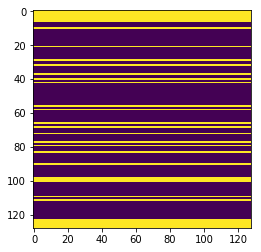

In [8]:
mask = gen_kspace_mask((128,128),ratio=0.17)
mask2 = gen_kspace_mask((128,128),ratio=0.2)
plt.imshow(mask.expand(1,1,128,128)[0,0])

## Analysize distance between exampls and kspace

In [ ]:
def norm(data):
    for d in data:
        d.add_(-d.min()).div_(d.max()-d.min()+0.000001) 
        
def norm2(data):
#     import pdb ; pdb.set_trace()
    tmp = data.transpose(0,1).contiguous().view(2,-1)
    mean = tmp.mean(1).view(1,2,1,1)
    std = tmp.std(1).view(1,2,1,1)
    data = (data - mean) / std
    
    
    return data
        
def pd(data):
    dis = []
    dis = torch.sum(torch.sum((data[:-1] - data[1:])**2,1),1)
    if len(dis.shape) > 1:
         dis = torch.sum(dis,1)
    dis = dis.cpu().numpy()
    
#     for i in range(data.shape[0]-1):
#         for j in range(i+1, data.shape[0]):
# #             import pdb ; pdb.set_trace()
#             d = torch.sum((data[i] - data[j])**2) #/ (128*128)
#             dis.append(float(d))
    return np.mean(dis), dis

def pd2(data):
    dis = []
    dis = (data[:-1] - data[1:])**2
    mean = torch.mean(dis,0)
    std = torch.std(dis,0)
    return mean, std

mask = mask.to(0)
kspaces, imgs = [], []    
for i, data in enumerate(testloader):
    if i > 50: break
    sys.stdout.write('\r iter '+str(i))
    sys.stdout.flush()
    if which_dataset == 'ImageNet':
        img,_,_ = data
    elif which_dataset == 'KNEE':
        _,img,_,_ = data
    img = img.to(0)
    fft_kspace = RFFT(img, normalized=True)
    
    masked_fft_kspace = fft_kspace * mask
    O = IFFT(masked_fft_kspace, normalized=True)
    # normalization
#     O = norm2(O)
#     masked_fft_kspace = norm2(masked_fft_kspace) 
    norm(O)
    norm(masked_fft_kspace) 
    masked_fft_kspace = masked_fft_kspace * mask # after image
    
    kspaces.append(masked_fft_kspace)
    imgs.append(O)
    
kspaces = torch.cat(kspaces,0)
imgs = torch.cat(imgs, 0)
    
pd_ksapce, pd_ksapce_arr = pd(kspaces[:,:,:,:]) # [B,H,W]
pd_img, pd_img_arr = pd(imgs[:,:,:,:])

plt.subplot(121)
_ = plt.hist(pd_ksapce_arr, bins=100)
plt.title('kspace data point PD')
plt.subplot(122)
_ = plt.hist(pd_img_arr, bins=100)
plt.title('imspace data point PD')

print('')
print('distance of kspace', pd_ksapce)
print('distance of image space', pd_img)

mean_ksapce, std_ksapce = pd2(kspaces[:,:,:,:]) # [B,H,W]
mean_img, std_img = pd2(imgs[:,:,:,:])


In [ ]:

plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(mean_ksapce[0], cmap='gray')
plt.title('kspace mean')
plt.axis('off')
plt.subplot(222)
plt.imshow(std_ksapce[0], cmap='gray')
plt.title('kspace std')
plt.axis('off')
plt.subplot(223)
plt.imshow(mean_img[0], cmap='gray')
plt.title('imspace mean')
plt.axis('off')
plt.subplot(224)
plt.imshow(std_img[0], cmap='gray')
plt.title('imspace std')
plt.axis('off')

## Inspect variability of remove-kspace-line masked image

In [ ]:
from PIL import Image
img = img.to(0)[:9,:,:,:]
from torchvision.utils import make_grid
fft_kspace = RFFT(img, normalized=True)
im_data = []
for i in range(100):
    mask = np.ones((img.shape[0],1,128,1),dtype=np.float32)
    for i in range(mask.shape[0]):
        idx = np.random.choice(range(5,122), 2)
        mask[i,:,idx,:] = 0
    mask = torch.from_numpy(mask).to(0)
    fft_kspace = RFFT(img, normalized=True)
    
    masked_fft_kspace = fft_kspace * mask
    I = IFFT(masked_fft_kspace, normalized=True)
    I.clamp_(-1,1).add_(1).div_(2)
    
    arr = make_grid(I[:,:1,:,:], nrow=3).permute(1,2,0) * 255.0
    
    im_data.append(arr)
    

im_data = [Image.fromarray(a.cpu().numpy().astype(np.uint8)[:,:,0]) for a in im_data]
im_data[0].save(fp='test.gif', format='gif', save_all=True, append_images=im_data[1:])


In [ ]:
# Show GIF
from IPython.display import Image
Image(filename="test.gif", )

In [ ]:
imn.max()

## Show image and corresponding Kspace

real rage nan nan
imag range 0.0 0.0
real rage nan nan
imag range 0.0 0.0
real rage nan nan
imag range 0.0 0.0
real rage nan nan
imag range 0.0 0.0
real rage nan nan
imag range 0.0 0.0
real rage nan nan
imag range 0.0 0.0
real rage nan nan
imag range 0.0 0.0


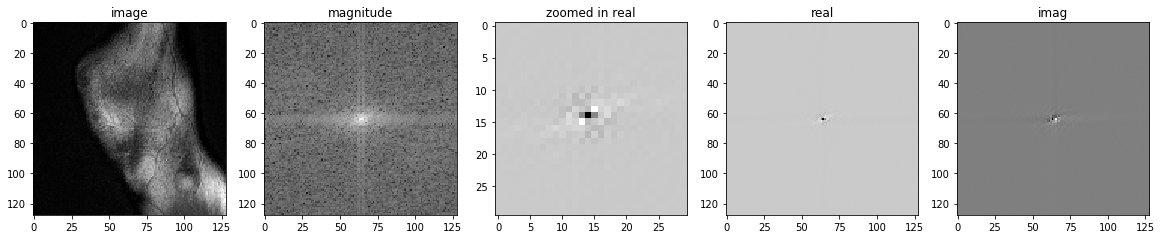

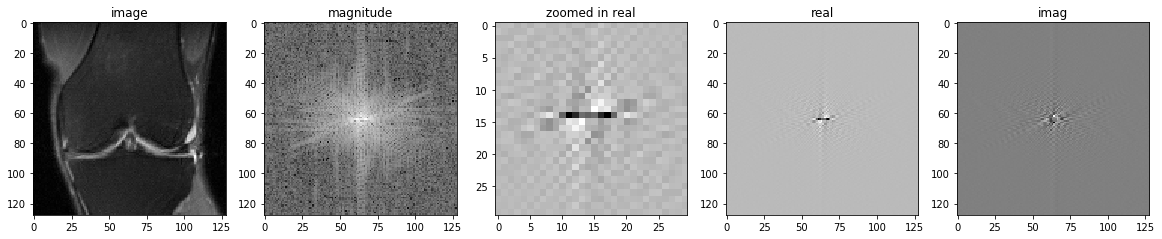

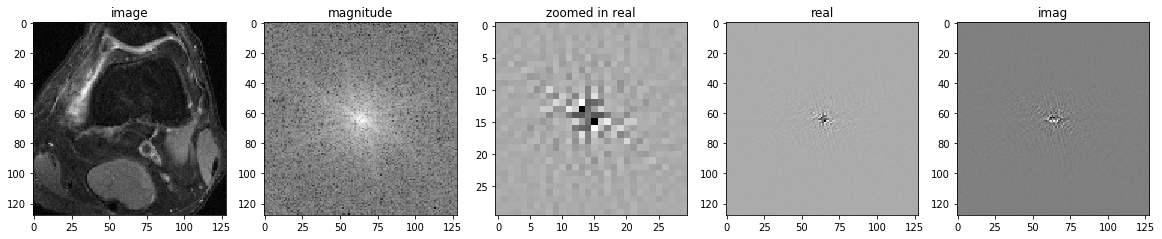

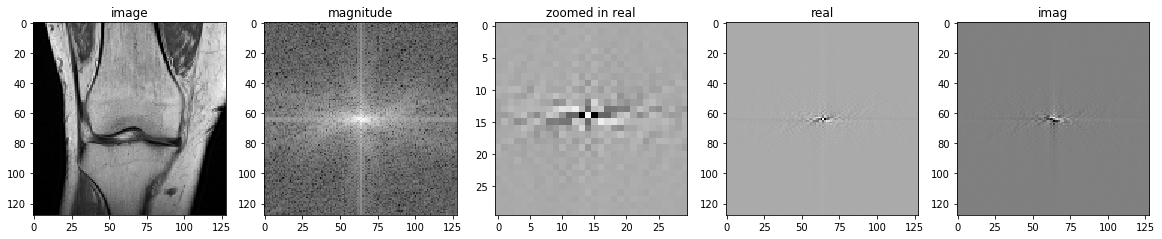

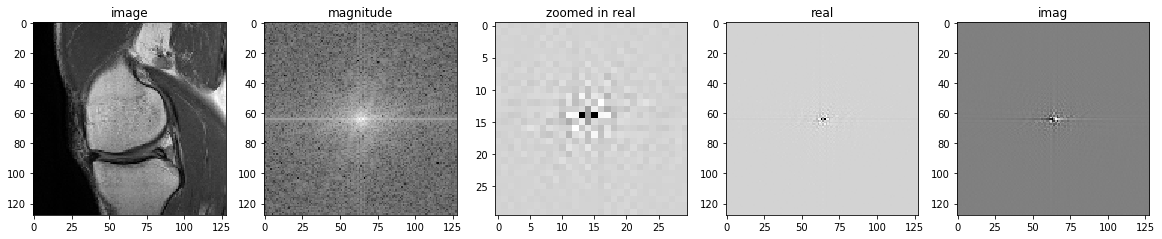

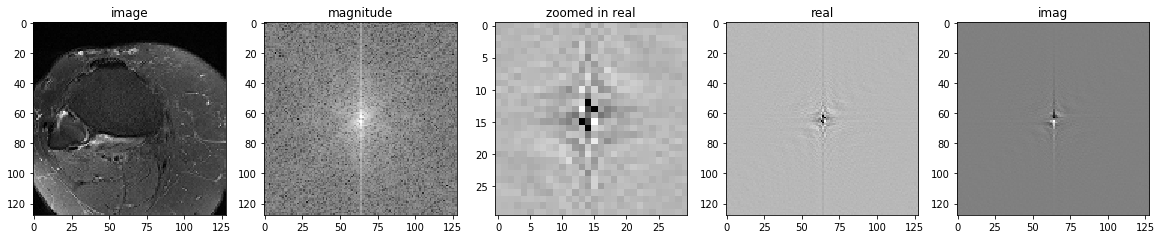

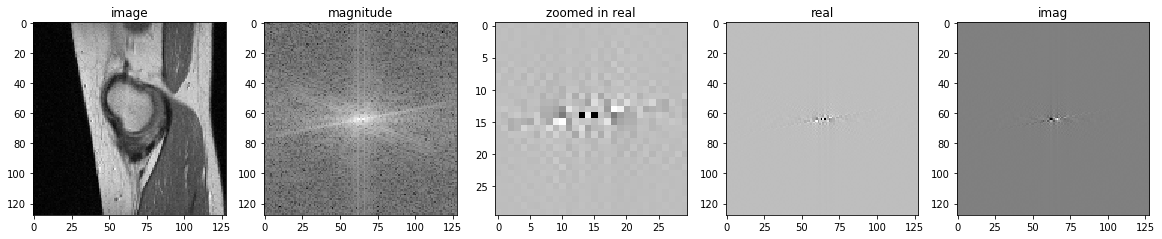

In [313]:
data = next(iter(testloader))
img = data[1]
def log(s):
#     sign = np.sign(s)
#     import pdb ; pdb.set_trace()
#     return np.log10(np.abs(s)) * sign
    return np.log(s)

import scipy.misc as misc
for i, im in enumerate(img):
    if i  > 6: break
    imn = im.cpu().numpy()[0]
    kspace = np.fft.fftshift(np.fft.fft2(imn)/(128*128))
#     kspace[20:25,:] = 0
    plt.figure(figsize=(20,50))
    plt.subplot(151)
    plt.imshow(imn, cmap='gray')
    plt.title('image')
    plt.subplot(152)
    plt.imshow(np.log(np.absolute(kspace)), cmap='gray')
    plt.title('magnitude')
    plt.subplot(153)
    # zoom in
    k_ = kspace[50:80,50:80]
    plt.imshow(k_.real, cmap='gray')
    plt.title('phase')
    plt.title('zoomed in real')
    plt.subplot(154)
    plt.imshow(kspace.real, cmap='gray')
    plt.title('real')
    plt.subplot(155)
    plt.imshow(kspace.imag, cmap='gray')
    plt.title('imag')
#     plt.title('zoomed in imag')
    kspace = log(kspace.real)
    print('real rage ' + str(kspace.real.min()), kspace.real.max())
    print('imag range ' + str(kspace.imag.min()), kspace.imag.max())



In [286]:
ifft.shape

(255, 255)

## Analyse the conjuate info in 2d kspace

Text(0.5,1,'filled ifft_img')

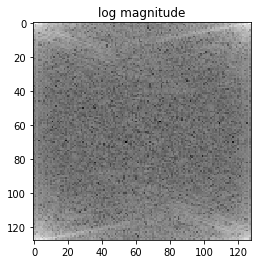

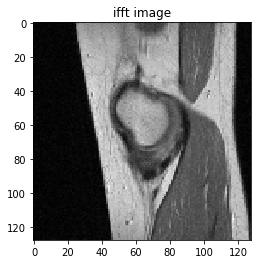

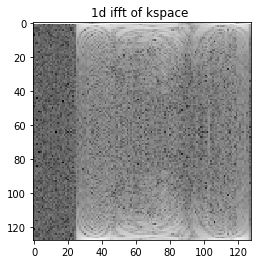

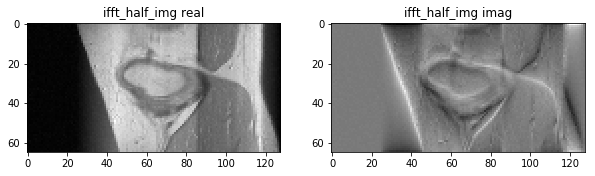

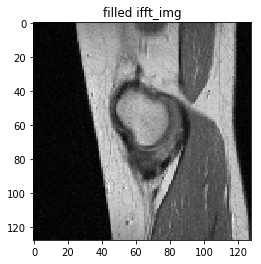

In [314]:
import scipy.misc as misc
img = data[1]

# imn = misc.imresize(imn_copy, (255,255))

kspace = np.zeros_like(imn) + 1j * 0
for i in range(imn.shape[1]):
    kspace[:,i] = np.fft.fft(imn[:,i])  
for i in range(imn.shape[0]):
    kspace[i] = np.fft.fft(kspace[i])
 
# kspace = np.fft.fft2(imn)
h = kspace.shape[0]

ifft_img = np.zeros_like(imn) + 1j * 0
for i in range(kspace.shape[0]):
    ifft_img[i] = np.fft.fft(kspace[i])  
for i in range(ifft_img.shape[1]):
    ifft_img[:,i] = np.fft.fft(ifft_img[:,i])

# ifft_img = np.fft.ifft2(kspace)
plt.imshow(np.log(np.absolute(kspace)), cmap='gray')
plt.title('log magnitude')

ifft = np.zeros_like(kspace)
for i in range(kspace.shape[0]):
    # row ifft
    ifft[i] = np.fft.ifft(kspace[i])

# ifft_kspace = np.zeros_like(kspace)
# for i in range(128):
#     ifft_kspace[:,i] = np.fft.fft(ifft[:,i])
ifft_img = np.fft.ifft2(kspace)
plt.figure()
plt.imshow(ifft_img.real, cmap='gray')
plt.title('ifft image')

plt.figure()
plt.imshow(np.log(np.absolute(ifft)), cmap='gray')
plt.title('1d ifft of kspace ')

##
plt.figure(figsize=(10,30))
plt.subplot(121)
ifft_half_img = np.fft.ifft2(kspace[:h//2+1])
plt.imshow(ifft_half_img.real, cmap='gray')
plt.title('ifft_half_img real')
plt.subplot(122)
plt.imshow(ifft_half_img.imag, cmap='gray')
plt.title('ifft_half_img imag')

h = kspace.shape[0]

## Lets do some analysis
part_fft = kspace[:h//2+1] #np.fft.fft2(ifft_half_img)

for i in range(len(part_fft)):
    # row ifft
    part_fft[i] = np.fft.ifft(part_fft[i])
h = kspace.shape[0]
ifft2 = np.zeros((h,h)) + 1j * 0
ifft2[:h//2+1,:] = part_fft
# row 1 to the last are symmetric
ifft2[h//2:,:][::-1] = np.conjugate(part_fft[1:])

for i in range(ifft2.shape[1]):
    # column ifft
    ifft2[:,i] = np.fft.ifft(ifft2[:,i])

plt.figure()
plt.imshow(ifft2.real, cmap='gray')
plt.title('filled ifft_img')


In [308]:
ifft.shape

(255, 255)

In [312]:
# ifft = np.zeros_like(imn) + 1j * 0
# for i in range(128):
#     ifft[i] = np.fft.fft(imn[i])
# for i in range(128):
#     ifft[:,i] = np.fft.fft(ifft[:,i])
# plt.imshow(ifft.real, cmap='gray')   
for i in range(1,128):
    d = np.absolute(ifft[i]) / np.absolute(ifft[255-i])
    print(d.min(), d.max())

0.9999999999997875 1.000000000000278
0.9999999999998769 1.000000000000114
0.9999999999999613 1.00000000000005
0.9999999999999245 1.0000000000001337
0.9999999999999358 1.0000000000000238
0.999999999999963 1.0000000000000333
0.9999999999999705 1.0000000000000275
0.9999999999999855 1.0000000000000226
0.9999999999999856 1.0000000000000178
0.9999999999999882 1.0000000000000204
0.9999999999999701 1.0000000000000266
0.9999999999999908 1.0000000000000158
0.9999999999999817 1.0000000000000102
0.9999999999999732 1.0000000000000142
0.9999999999999897 1.0000000000000748
0.9999999999999848 1.0000000000000329
0.9999999999999892 1.0000000000000075
0.9999999999999793 1.0000000000000193
0.9999999999999836 1.0000000000000229
0.9999999999999387 1.0000000000000262
0.9999999999999745 1.0000000000000484
0.999999999999991 1.0000000000000095
0.9999999999999749 1.000000000000011
0.9999999999999887 1.0000000000000302
0.9999999999999853 1.0000000000000144
0.9999999999999414 1.0000000000000446
0.9999999999999786 

In [214]:
(ifft[1:65].real / ifft[64:][::-1].real)[2]

array([1.        , 0.9999632 , 1.        , 0.9999805 , 1.        ,
       1.0000052 , 0.99998003, 0.9999873 , 1.        , 1.0000035 ,
       1.0000705 , 1.0000093 , 0.99999696, 1.0000079 , 0.9999994 ,
       1.        , 0.9999878 , 1.0000026 , 1.0000075 , 1.0000023 ,
       1.0000038 , 0.9999667 , 1.0000156 , 1.0000021 , 1.0000002 ,
       1.0000001 , 1.        , 1.        , 1.0000002 , 1.        ,
       1.        , 1.        , 0.9999998 , 0.99999994, 1.        ,
       1.        , 0.9999997 , 0.99999976, 0.9999998 , 1.0000002 ,
       1.0000004 , 0.99999964, 1.0000001 , 0.99999964, 1.0000001 ,
       1.        , 1.0000001 , 1.0000004 , 0.9999998 , 0.9999997 ,
       0.99999905, 1.0000036 , 0.9999995 , 1.0000005 , 0.9999992 ,
       1.0000019 , 1.0000007 , 1.0000001 , 1.0000004 , 1.0000001 ,
       1.        , 1.0000001 , 0.9999998 , 1.0000001 , 1.        ,
       0.9999998 , 1.        , 0.99999994, 1.        , 0.9999999 ,
       1.        , 1.        , 1.        , 1.        , 0.99999

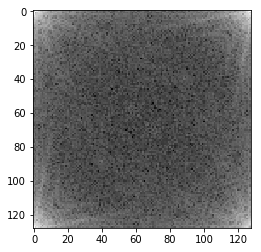

In [48]:
plt.imshow(np.log(np.absolute(D)), cmap='gray')

In [ ]:
kspace = np.fft.fft2(imn) / (128 * 128)
print(kspace.min(), kspace.max())

In [ ]:
imn = (imn - imn.min()) / (imn.max() - imn.min())
imn.min()

In [ ]:
kspace.k_

In [71]:
import sys
MV = 10000
LV = -1000
for i, data in enumerate(testloader):
    img = data[0]
    if i  > 2000: break
    fft_kspace = RFFT(img) / (128*128)
    real = fft_kspace[:,0,:,:]
    imag = fft_kspace[:,1,:,:]
#     real = real.add_(1).log2_()
#     imag = imag.add_(1).log2_()
    
    minv = min(float(real.min()), float(imag.min()))
    maxv = max(float(real.max()), float(imag.max()))
    
    if minv < MV: MV = minv
    if maxv > LV: LV = maxv
    sys.stdout.write('\r real rage ' + str(real.min().item()) +' ' + str(real.max().item()) + 
           '  imag range ' + str(imag.min().item()) +' '+ str(imag.max().item()))
    
    sys.stdout.flush()
#     masked_fft_kspace = fft_kspace * mask[:1,:,:,:].cpu()
#     I = IFFT(masked_fft_kspace, normalized=True)
#     print(fft_kspace.max(), fft_kspace.min())
print('\n smallest value', MV)
print('\n maximum value', LV)


 real rage -0.05161559581756592 0.7824695110321045  imag range -0.12611407041549683 0.1261140853166580234
 smallest value -0.2590959966182709

 maximum value 0.9593245387077332


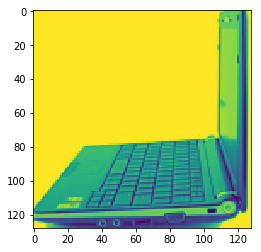

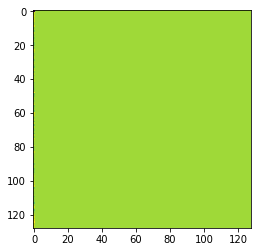

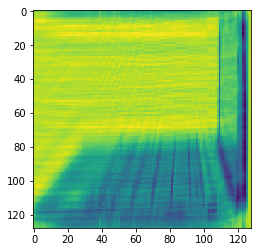

In [66]:
def to_net_input(input):
    # to go log space
    out = input.div(128*128) # normalize kspace
    out = out.add(2).log()
    return out

def to_net_output(out):
    # copy data
    out = out.exp().add(-2)
    out.mul(128*128)

    return out

plt.imshow(img[0][0])    
fft_kspace = RFFT(img)

fft_kspace2 = to_net_input(fft_kspace)
fft_kspace2 = fft_kspace2 * mask
fft_kspace3 = to_net_output(fft_kspace2)
img2 = IFFT(fft_kspace3)
plt.figure()
plt.imshow(img2[0][0])  


fft_kspace5 = RFFT(img)
fft_kspace6 = fft_kspace5 * mask
fft_kspace6 = to_net_input(fft_kspace6)
fft_kspace7 = to_net_output(fft_kspace6)
img2 = IFFT(fft_kspace7)
plt.figure()
plt.imshow(img2[0][0]) 

In [60]:
torch.Tensor(1).fill_(10).log_().exp()

tensor([ 10.])

In [64]:
fft_kspace5.shape

torch.Size([12, 2, 128, 128])

In [ ]:
fft_kspace = RFFT(img, normalized=True)
masked_fft_kspace = fft_kspace * mask[:1,:,:,:].cpu()
O = IFFT(masked_fft_kspace, normalized=True)[:,:1,:,:] # drop the imaginary part!!

masked_fft_kspace = fft_kspace * (1- mask[:1,:,:,:].cpu())
U = IFFT(masked_fft_kspace, normalized=True)[:,:1,:,:] # drop the imaginary part!!

# merge in kspace
O_kspace = RFFT(O, normalized=True)
U_kspace = RFFT(U, normalized=True)
F_kspace = O_kspace * mask[:1,:,:,:].cpu() + (1- mask[:1,:,:,:].cpu()) * U_kspace

F = IFFT(F_kspace, normalized=True)

plt.imshow(img[0][0])
plt.figure()
plt.imshow(F[0][0])
plt.title('Merged Full observed image')

# evalate the visiable part loss
F_kspace2 = FFT(F, normalized=True) * mask[:1,:,:,:].cpu()
dd = F_kspace2[:,:1,:,:] - masked_fft_kspace[:,:1,:,:]
dd = IFFT(F_kspace2)[:,:1,:,:] - O

print('difference range {} {}'.format(dd.min(), dd.max()))


In [ ]:


## test
# # way 1
# fft_kspace = RFFT(I[:,:1,:,:], normalized=True)
# fft_kspace = fft_kspace * (mask2)
# I1 = IRFFT(fft_kspace, normalized=True)[:,:1,:,:]
# # print(I1.min(), I1.max())

# # way two
# fft_kspace = FFT(I, normalized=True)
# fft_kspace = fft_kspace * (mask2)
# I2 = IFFT(fft_kspace, normalized=True)[:,:1,:,:]
# print(I2.min(), I2.max())

# # way 1
# fft_kspace = RFFT(I[:,:1,:,:], normalized=True)
# I1 = IRFFT(fft_kspace, normalized=True)[:,:1,:,:]
# print(I1.min(), I1.max())

# # way two
# fft_kspace = FFT(I, normalized=True)
# I2 = IFFT(fft_kspace, normalized=True)[:,:1,:,:]
# print(I2.min(), I2.max())

plt.figure()
plt.imshow(I1[0,0])
plt.title('IFFT(masked kspace) real part')
plt.figure()
plt.imshow(I2[0,0])
plt.title('IRFFT(masked kspace)')

plt.figure()
plt.imshow(I2[0,0] - I[0,0], cmap='gray')
plt.title('difference imag')

dd = I2[0,0] - I[0,0]
print('difference range {} {}'.format(dd.min(), dd.max()))

In [ ]:
# do kspace masking and ifft
for im in img:
    im.add_(-im.min()).div_(im.max()-im.min()).mul_(2).add_(-1)
fft_kspace = RFFT(img, normalized=True)
masked_kspace = fft_kspace * mask[:1]
O = IFFT(masked_kspace, normalized=True)
idx = torch.nonzero(mask[0,0,:,0]).view(-1)
selected_ksapce = masked_kspace[:,:,idx,:]
OS = IFFT(selected_ksapce, normalized=True)

In [ ]:
fft_kspace.max()

In [ ]:
plt.figure(figsize=(20,40))
plt.subplot(121)
plt.imshow(selected_ksapce[0][0], cmap='gray')
plt.title('selected masked kspace')
plt.subplot(122)
plt.imshow(OS[0][0], cmap='gray')

plt.figure(figsize=(20,40))
plt.subplot(121)
plt.imshow(masked_kspace[0][0], cmap='gray')
plt.title('masked kspace')
plt.subplot(122)
plt.imshow(O[0][0], cmap='gray')

In [ ]:
plt.figure(figsize=(20,40))
plt.subplot(131)
plt.imshow(img[0][0], cmap='gray')
plt.title('A img')
plt.subplot(132)
plt.imshow(O[0][0], cmap='gray')
plt.title('B iift(masked ksapce) real')
plt.subplot(133)
plt.imshow(O[0][1], cmap='gray')
plt.title('C iift(masked ksapce) imaginary')

plt.figure(figsize=(20,40))
plt.subplot(131)
plt.imshow(O[0].norm(dim=0), cmap='gray')
plt.title('D magnitude')
plt.subplot(132)

complex_img = O[0][0].cpu().numpy() + 1j*O[0][1].cpu().numpy()
plt.imshow(np.angle(complex_img), cmap='gray')
plt.title('E phase')


In [200]:
a = [1,2,3,4]
a[:1:-1]

[4, 3]

In [175]:
a = 1 + 2j

In [179]:
a * (1-1j)

(3+1j)

In [180]:
1-1j

(1-1j)